# Pytorch Tutorial

## Learn the basics

* Website: https://pytorch.org/tutorials/beginner/basics/intro.html
* Topic: Use the FashionMNIST dataset to train a neural network that predicts if an input image belongs to one of the following classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, or Ankle boot.

### Quickstart

PyTorch has [two primitives to work with data](https://pytorch.org/docs/stable/data.html): `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset`.

In [1]:
'''
PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, 
all of which include datasets. For this tutorial, we will be using a TorchVision dataset.
'''

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

In [37]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [38]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [4]:
'''
We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, 
and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we 
define a batch size of 64, i.e. each element in the dataloader iterable will return a batch 
of 64 features and labels.
'''

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [16]:
test_dataloader

#### Visualize the dataset

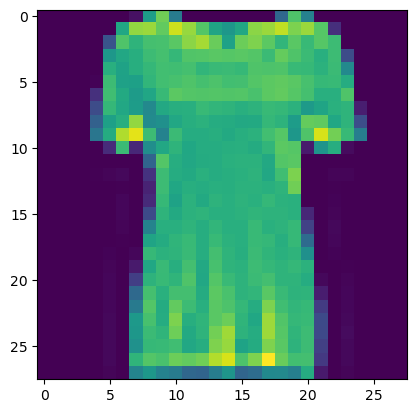

torch.Size([1, 28, 28]) torch.Size([28, 28]) label: 0


In [43]:
import matplotlib.pyplot as plt

image, label = training_data[10]
plt.imshow(image.squeeze(), cmap="viridis")
plt.show()

print(image.shape, image.squeeze().shape, 'label:', label)

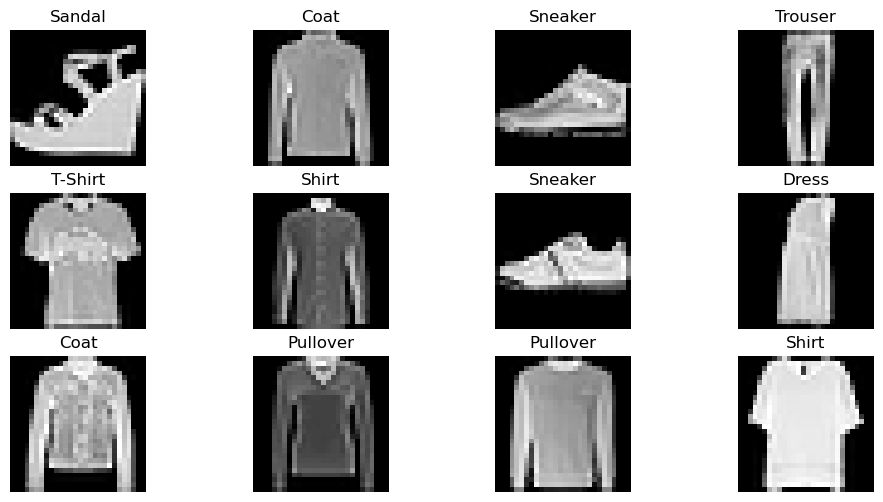

In [5]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(12, 6))
cols, rows = 4, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Creating a model

In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

Using cpu device


In [14]:
 # Visualizing Pipelines in HTML
from sklearn import set_config; set_config(display='diagram')
from sklearn.pipeline import Pipeline

Pipeline(model)

Pipeline(steps=NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
))

#### Optimizing the Model Parameters

In [49]:
#To train a model, we need a loss function and an optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-3)

In [44]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [45]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [50]:
epochs = 6
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.188125  [    0/60000]
loss: 1.179318  [ 6400/60000]
loss: 0.987845  [12800/60000]
loss: 1.104738  [19200/60000]
loss: 0.964590  [25600/60000]
loss: 0.987336  [32000/60000]
loss: 1.029477  [38400/60000]
loss: 0.957790  [44800/60000]
loss: 0.983996  [51200/60000]
loss: 0.927414  [57600/60000]
Test Error: 
 Accuracy: 66.6%, Avg loss: 0.926031 

Epoch 2
-------------------------------
loss: 0.975217  [    0/60000]
loss: 1.014645  [ 6400/60000]
loss: 0.794598  [12800/60000]
loss: 0.955297  [19200/60000]
loss: 0.826830  [25600/60000]
loss: 0.837009  [32000/60000]
loss: 0.916069  [38400/60000]
loss: 0.856058  [44800/60000]
loss: 0.875189  [51200/60000]
loss: 0.838520  [57600/60000]
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.829565 

Epoch 3
-------------------------------
loss: 0.851185  [    0/60000]
loss: 0.923581  [ 6400/60000]
loss: 0.685855  [12800/60000]
loss: 0.872659  [19200/60000]
loss: 0.753713  [25600/60000]
loss: 0.749909  [32000/600

#### Hyperparameter tuning with Ray Tune

* Website: https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

The following are hyperparameters for training:
- **Number of Epochs** - the number times to iterate over the dataset
- **Batch Size** - the number of data samples propagated through the network before the parameters are updated
- **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [48]:
learning_rate = 1e-3
batch_size = 64
epochs = 5